**Libraries Used**

In [1]:
import os
import cv2
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

**Importing Segment Anything Model package and also pre trained model**

In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-v2fv8jx4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-v2fv8jx4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [3]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-02-08 21:10:03--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.202.120, 18.164.202.35, 18.164.202.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.202.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  5.00MB/s    in 3m 57s  

2024-02-08 21:14:00 (10.3 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



**Reading the Images**

In [2]:
def read_images_in_folder(folder_path): #Read images from a folder
    image_list = []
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        img = Image.open(image_path)
        image_list.append(img)

    return image_list  #Returns a list of Images read from the folder 
images = read_images_in_folder("Images")

**Finding Bounding Boxes for getting centers**

In [3]:
def find_contours(drone_image): #Find contours in a given drone image.
    drone_image = np.array(drone_image)
    gray_image = cv2.cvtColor(drone_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    edges = cv2.Canny(blurred_image, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours,blurred_image,edges,drone_image # Return detected contours, blurred image, edges, and original drone image

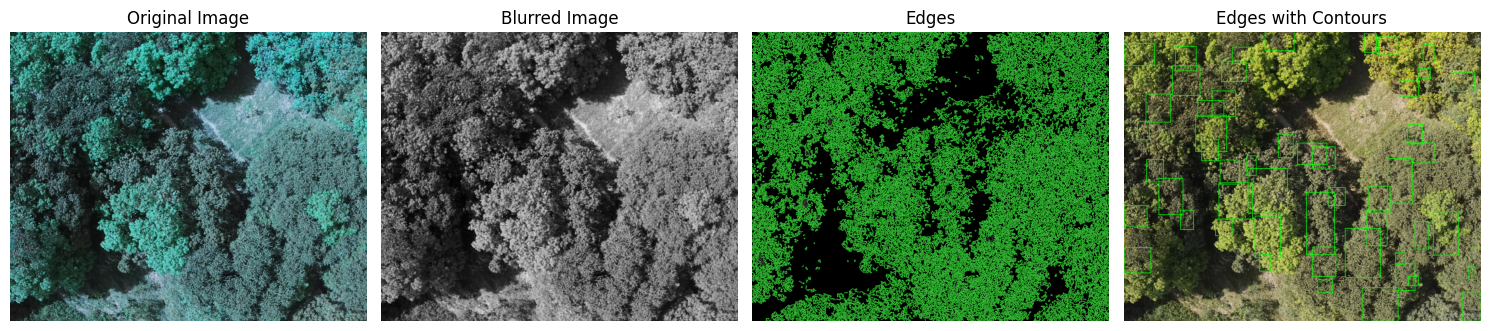

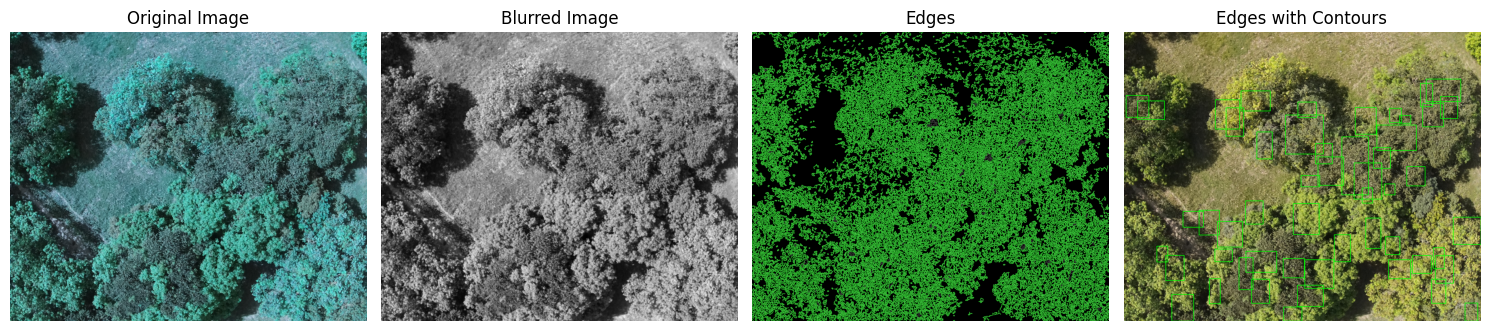

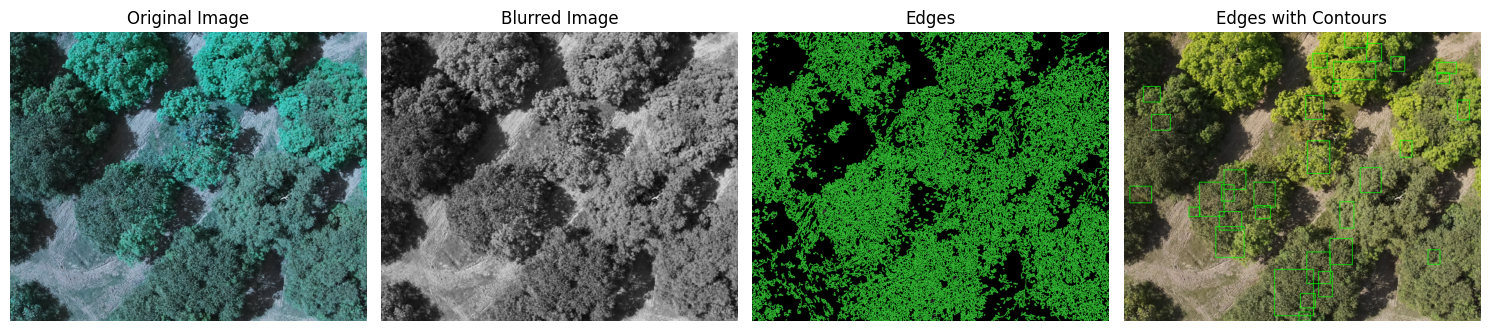

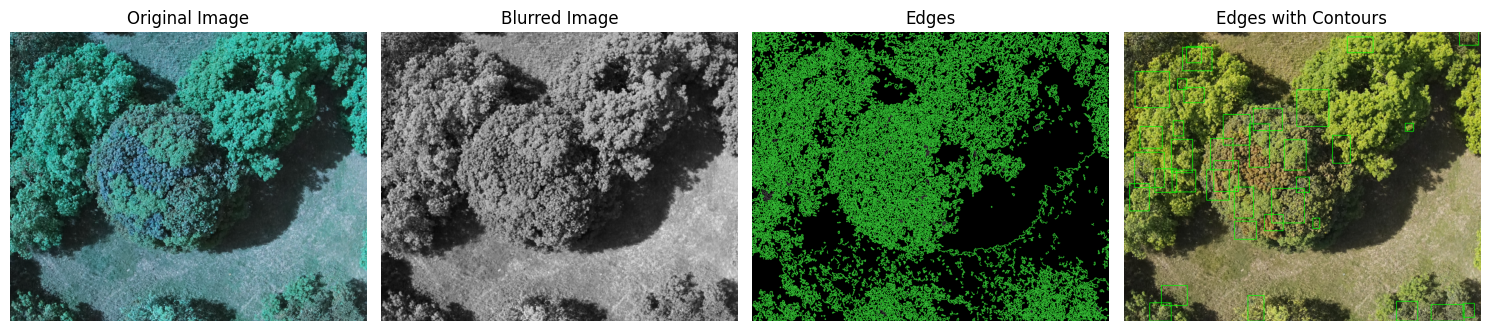

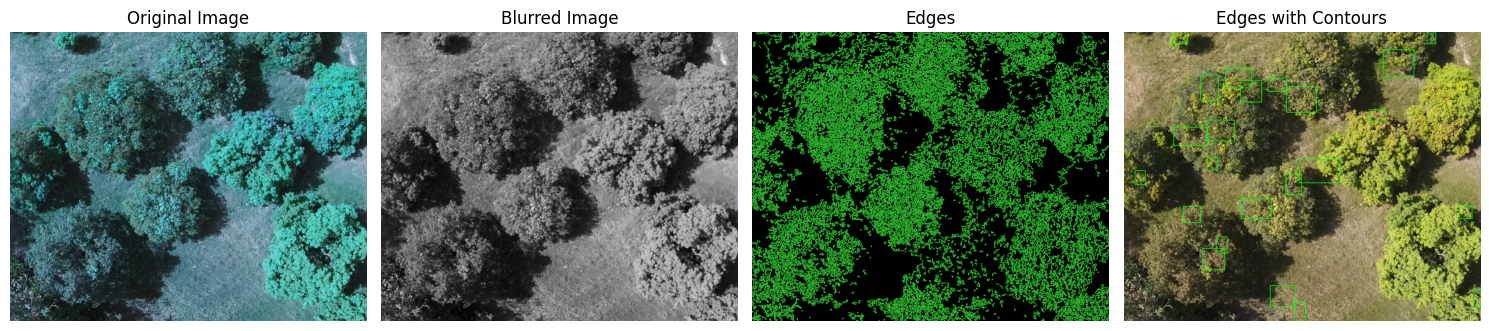

In [7]:
def process_and_display_images(drone_image):  #Process and display images with detected contours.
    contours,blurred_image,edges,drone_image = find_contours(drone_image)
    detected_trees = []
    o_image = drone_image.copy()
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            x, y, w, h = cv2.boundingRect(contour)
            detected_trees.append((x, y, x + w, y + h))
    for tree in detected_trees:  # Draw rectangles around detected trees on the original image
        x1, y1, x2, y2 = tree
        cv2.rectangle(drone_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    contour_image = np.zeros_like(drone_image)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2) # Draw contours on the contour image
    #Displays the original image, blurred image, edges, and edges with contours overlaid.
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    axs[0].imshow(cv2.cvtColor(o_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(blurred_image, cmap='gray')
    axs[1].set_title('Blurred Image')
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
    axs[2].imshow(contour_image, alpha=0.5)
    axs[2].set_title('Edges')
    axs[2].axis('off')

    axs[3].imshow(drone_image)
    axs[3].set_title('Edges with Contours')
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()
    return detected_trees
detected_trees = []
for image in images:
    detected_trees.append(process_and_display_images(image))

**Applying pretrained Segment Anything Model for the centers from above Bounding Boxes**

In [5]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

def getMasks(image, reqPts):
    predictor.set_image(image)
    allMasks = []
    complete_mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)
    for i in reqPts:
        x,y = (i[0]+i[2])//2, (i[1]+i[3])//2
        if(complete_mask[y,x] == True):
          continue
        masks, scores, logits = predictor.predict(
          point_coords=np.array([[(i[0]+i[2])//2, (i[1]+i[3])//2]]),
          point_labels=np.array([1]),
          multimask_output=True,
        )
        top_score = 0
        best_mask = None
        for i, score in enumerate(scores):
          if score > top_score:
            top_score = score
            best_mask = masks[i]
        allMasks.append(best_mask)
        complete_mask += best_mask
    return allMasks

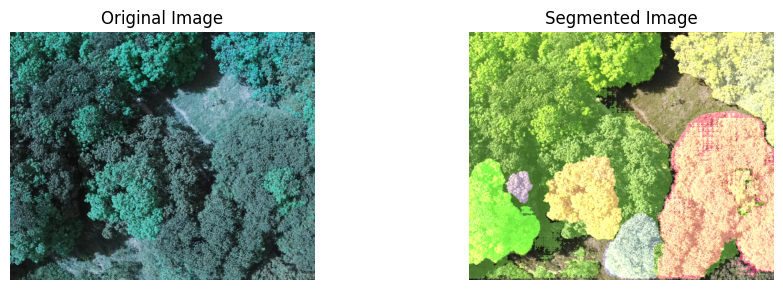

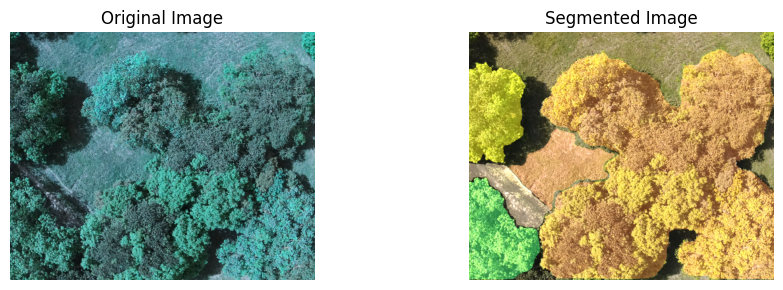

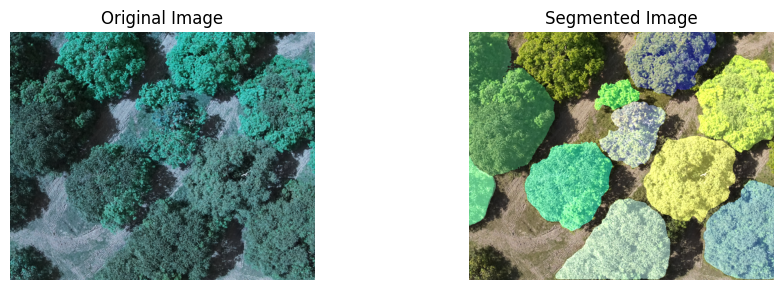

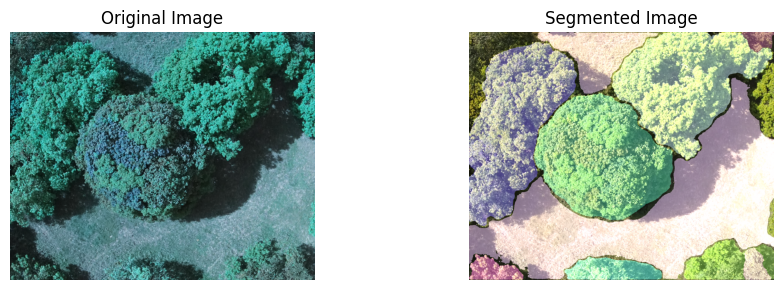

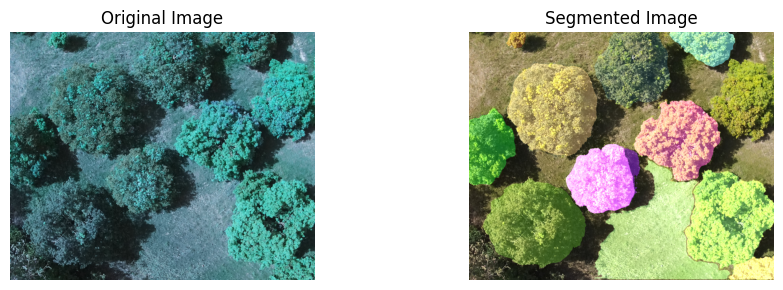

In [8]:
for ind, image in enumerate(images):
    image = np.array(image)
    masks = getMasks(image, detected_trees[ind])
    result = []
    for ind,mask in enumerate(masks):
        masks[ind] = (mask > 0).astype(np.uint8) * 255
        color = np.random.randint(0, 256, (1, 3), dtype=np.uint8)
        color_mask = cv2.cvtColor(masks[ind], cv2.COLOR_GRAY2BGR)
        opacity = 0.5
        if(len(result)):
            result = cv2.addWeighted(result, 1, color_mask * color, opacity, 0)
        else:
            result = cv2.addWeighted(image, 1, color_mask * color, opacity, 0)
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(result, cmap='gray')
    axs[1].set_title('Segmented Image')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()